# Seq2seq LSTM

## Import packages

In [39]:
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pickle

import numpy as np
import pandas as pd
import random
import math

import os, os.path 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import time
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

%matplotlib inline

In [40]:
# set random state

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [78]:
test_1 = np.random.uniform(0, 10, size=6)
test_1

array([1.98842404, 7.11341953, 7.90175541, 6.05959975, 9.26300879,
       6.51077026])

In [111]:
test_1

array([1.98842404, 7.11341953, 7.90175541, 6.05959975, 9.26300879,
       6.51077026])

In [124]:
test = test_1.copy()

In [127]:
np.random.seed(SEED)
np.random.shuffle(test)

In [130]:
np.random.seed(SEED)
shuffler = np.random.permutation(10)
shuffler

array([8, 1, 5, 0, 7, 2, 9, 4, 3, 6])

In [126]:
test

array([1.98842404, 7.11341953, 6.51077026, 7.90175541, 9.26300879,
       6.05959975])

## Define Dataloader

In [7]:
ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"] 

def get_city_trajectories(city="palo-alto", split="train", SEED=42):

    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)

        np.random.seed(SEED)
        shuffler = np.random.permutation(n)
        
        inputs = np.asarray(inputs)
        inputs = inputs[shuffler]
        inputs = inputs[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        outputs = outputs[shuffler]
        outputs = outputs[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)

        np.random.seed(SEED)
        shuffler = np.random.permutation(n)
        
        inputs = np.asarray(inputs)
        inputs = inputs[shuffler]
        inputs = inputs[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        outputs = outputs[shuffler]
        outputs = outputs[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        outputs = torch.zeros(n,60, 2).to(device)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [4]:
torch.cuda.current_device()

0

In [5]:
!nvidia-smi

Fri May 27 03:36:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 107...  Off  | 00000000:05:00.0 Off |                  N/A |
| 50%   61C    P5    10W / 180W |   5731MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Define the Seq2Seq Model

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.seq_len = input_dim[0]
        self.inp_feat_dim = input_dim[1]
        self.n_layers = n_layers
        
        
        self.lstm = nn.LSTM(input_size = self.inp_feat_dim, hidden_size = hid_dim, num_layers = n_layers, 
                            dropout = dropout, batch_first = True)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inp):
    
        #input = [batch size, inp len, feat dim]
        
        outputs, (hidden, cell) = self.lstm(inp)
        
        #outputs = [batch size, src len, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [7]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, dropout = 0.0):
        super().__init__()
        
        self.output_dim = output_dim # 2 for (x,y)
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        
        self.lstm = nn.LSTM(output_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size, feat_size]
                
        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [8]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = torch.Size([128, 50, 2])
        #trg = torch.Size([128, 60, 2])
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_feat_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_feat_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the input's first point * batch size
        input = src[:,49,:]
        
        for t in range(0, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[:,t,:] if teacher_force else output
        
        
        #transpose the matrix's and dimension to use old csv output pipeline
        outputs = outputs.transpose(1,0)
        
        return outputs

## Training the Seq2Seq Model

In [9]:
INPUT_DIM = (50,2)
OUTPUT_DIM = 2
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Seq2Seq(enc, dec, device).to(device)

In [10]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(2, 512, num_layers=2, batch_first=True, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (lstm): LSTM(2, 512, num_layers=2, dropout=0.3)
    (fc_out): Linear(in_features=512, out_features=2, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,317,058 trainable parameters


In [12]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [13]:
criterion = nn.MSELoss()

In [14]:
def train(model, train_loader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(train_loader):
        
        src, trg = batch
        
        src = src.to(device)
        src = src.float()
        trg = trg.to(device)
        trg = trg.float()
            
        optimizer.zero_grad()
        
        output = model(src, trg, 0.5)
        
        #trg = [batch size, trg len, trg feat]
        #output = [batch size, trg len, out dim]    
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_loader)

In [15]:
def evaluate(model, val_loader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(val_loader):

            src, trg = batch

            src = src.to(device)
            src = src.float()
            trg = trg.to(device)
            trg = trg.float()
            
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(val_loader)


In [16]:
# function that tells how long an epoch takes
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### 1. "Teacher-forcing" = 0.5 & drop_out = 0.3 & 2 layer

city: austin
Epoch: 01 | Time: 0m 36s
	Train Loss: 1988658.585 | Val. Loss: 1851486.901
Epoch: 02 | Time: 0m 36s
	Train Loss: 1735287.645 | Val. Loss: 1619875.674
Epoch: 03 | Time: 0m 36s
	Train Loss: 1527393.036 | Val. Loss: 1434305.380
Epoch: 04 | Time: 0m 36s
	Train Loss: 1363791.871 | Val. Loss: 1292721.925
Epoch: 05 | Time: 0m 36s
	Train Loss: 1234152.992 | Val. Loss: 1178662.840
Epoch: 06 | Time: 0m 36s
	Train Loss: 1133103.314 | Val. Loss: 1084972.771
Epoch: 07 | Time: 0m 32s
	Train Loss: 1053449.836 | Val. Loss: 1014233.719
Epoch: 08 | Time: 0m 36s
	Train Loss: 989314.439 | Val. Loss: 957617.869
Epoch: 09 | Time: 0m 36s
	Train Loss: 933329.301 | Val. Loss: 903869.668
Epoch: 10 | Time: 0m 36s
	Train Loss: 882389.836 | Val. Loss: 854840.312
Epoch: 11 | Time: 0m 37s
	Train Loss: 835802.677 | Val. Loss: 808193.475
Epoch: 12 | Time: 0m 36s
	Train Loss: 791830.665 | Val. Loss: 767255.021
Epoch: 13 | Time: 0m 36s
	Train Loss: 752286.220 | Val. Loss: 728830.665
Epoch: 14 | Time: 0m 37s

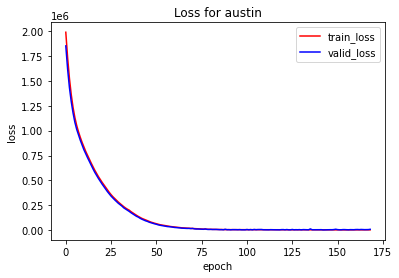

city: miami
Epoch: 01 | Time: 0m 47s
	Train Loss: 1780054.605 | Val. Loss: 1448749.512
Epoch: 02 | Time: 0m 47s
	Train Loss: 1244388.149 | Val. Loss: 1126178.049
Epoch: 03 | Time: 0m 45s
	Train Loss: 999416.515 | Val. Loss: 926173.635
Epoch: 04 | Time: 0m 47s
	Train Loss: 814946.447 | Val. Loss: 757721.207
Epoch: 05 | Time: 0m 47s
	Train Loss: 669033.236 | Val. Loss: 627592.851
Epoch: 06 | Time: 0m 46s
	Train Loss: 569530.377 | Val. Loss: 541151.892
Epoch: 07 | Time: 0m 46s
	Train Loss: 491611.069 | Val. Loss: 463031.223
Epoch: 08 | Time: 0m 47s
	Train Loss: 415550.011 | Val. Loss: 395115.295
Epoch: 09 | Time: 0m 47s
	Train Loss: 354793.342 | Val. Loss: 335448.174
Epoch: 10 | Time: 0m 46s
	Train Loss: 305150.583 | Val. Loss: 287797.184
Epoch: 11 | Time: 0m 47s
	Train Loss: 263800.941 | Val. Loss: 255449.321
Epoch: 12 | Time: 0m 46s
	Train Loss: 230277.702 | Val. Loss: 228393.010
Epoch: 13 | Time: 0m 46s
	Train Loss: 207870.014 | Val. Loss: 203306.510
Epoch: 14 | Time: 0m 47s
	Train Los

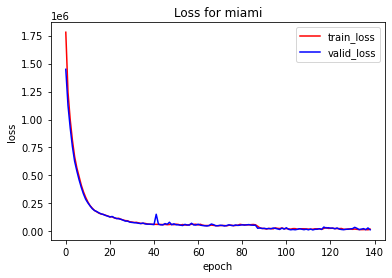

city: pittsburgh
Epoch: 01 | Time: 0m 36s
	Train Loss: 128887.732 | Val. Loss: 54416.220
Epoch: 02 | Time: 0m 37s
	Train Loss: 46111.040 | Val. Loss: 54259.831
Epoch: 03 | Time: 0m 37s
	Train Loss: 41630.986 | Val. Loss: 35599.429
Epoch: 04 | Time: 0m 33s
	Train Loss: 32665.177 | Val. Loss: 46131.571
Epoch: 05 | Time: 0m 33s
	Train Loss: 25720.471 | Val. Loss: 22077.010
Epoch: 06 | Time: 0m 33s
	Train Loss: 30656.175 | Val. Loss: 24201.823
Epoch: 07 | Time: 0m 35s
	Train Loss: 27026.998 | Val. Loss: 37054.843
Epoch: 08 | Time: 0m 37s
	Train Loss: 29963.543 | Val. Loss: 20317.209
Epoch: 09 | Time: 0m 37s
	Train Loss: 21666.974 | Val. Loss: 25396.286
Epoch: 10 | Time: 0m 37s
	Train Loss: 22328.241 | Val. Loss: 18522.860
Epoch: 11 | Time: 0m 37s
	Train Loss: 20898.034 | Val. Loss: 26521.026
Epoch: 12 | Time: 0m 37s
	Train Loss: 22337.823 | Val. Loss: 20579.336
Epoch: 13 | Time: 0m 37s
	Train Loss: 26684.340 | Val. Loss: 18054.932
Epoch: 14 | Time: 0m 37s
	Train Loss: 22895.419 | Val. Loss

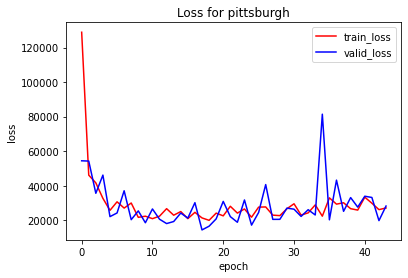

city: dearborn
Epoch: 01 | Time: 0m 21s
	Train Loss: 3031299.019 | Val. Loss: 2469477.424
Epoch: 02 | Time: 0m 21s
	Train Loss: 2335561.501 | Val. Loss: 2190765.855
Epoch: 03 | Time: 0m 21s
	Train Loss: 2250566.865 | Val. Loss: 2141316.546
Epoch: 04 | Time: 0m 21s
	Train Loss: 1989587.169 | Val. Loss: 1762897.562
Epoch: 05 | Time: 0m 21s
	Train Loss: 1736619.937 | Val. Loss: 1685378.638
Epoch: 06 | Time: 0m 21s
	Train Loss: 1684427.526 | Val. Loss: 1598641.789
Epoch: 07 | Time: 0m 21s
	Train Loss: 1573048.340 | Val. Loss: 1508376.842
Epoch: 08 | Time: 0m 20s
	Train Loss: 1465890.850 | Val. Loss: 1394656.974
Epoch: 09 | Time: 0m 20s
	Train Loss: 1375126.219 | Val. Loss: 1320537.931
Epoch: 10 | Time: 0m 21s
	Train Loss: 1332130.442 | Val. Loss: 1253044.725
Epoch: 11 | Time: 0m 21s
	Train Loss: 1347556.070 | Val. Loss: 1244621.620
Epoch: 12 | Time: 0m 21s
	Train Loss: 1327855.043 | Val. Loss: 1179233.372
Epoch: 13 | Time: 0m 21s
	Train Loss: 1281684.876 | Val. Loss: 1190752.211
Epoch: 14 

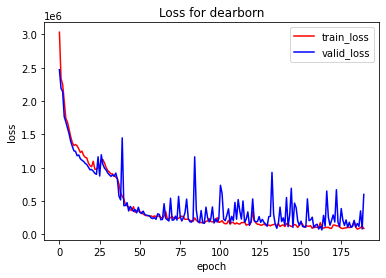

city: washington-dc
Epoch: 01 | Time: 0m 21s
	Train Loss: 462837.730 | Val. Loss: 127700.836
Epoch: 02 | Time: 0m 21s
	Train Loss: 128415.085 | Val. Loss: 73579.371
Epoch: 03 | Time: 0m 22s
	Train Loss: 73544.767 | Val. Loss: 56707.448
Epoch: 04 | Time: 0m 23s
	Train Loss: 54736.164 | Val. Loss: 38742.782
Epoch: 05 | Time: 0m 22s
	Train Loss: 42992.468 | Val. Loss: 36788.290
Epoch: 06 | Time: 0m 21s
	Train Loss: 35850.667 | Val. Loss: 34601.455
Epoch: 07 | Time: 0m 21s
	Train Loss: 29956.917 | Val. Loss: 32492.171
Epoch: 08 | Time: 0m 22s
	Train Loss: 26908.080 | Val. Loss: 27285.931
Epoch: 09 | Time: 0m 23s
	Train Loss: 26128.930 | Val. Loss: 28280.634
Epoch: 10 | Time: 0m 22s
	Train Loss: 24243.904 | Val. Loss: 17891.691
Epoch: 11 | Time: 0m 22s
	Train Loss: 27243.310 | Val. Loss: 54241.391
Epoch: 12 | Time: 0m 22s
	Train Loss: 24678.235 | Val. Loss: 21038.318
Epoch: 13 | Time: 0m 23s
	Train Loss: 25110.236 | Val. Loss: 22702.137
Epoch: 14 | Time: 0m 23s
	Train Loss: 23231.679 | Val.

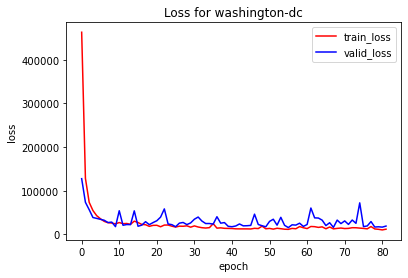

city: palo-alto
Epoch: 01 | Time: 0m 10s
	Train Loss: 67033.091 | Val. Loss: 24405.879
Epoch: 02 | Time: 0m 10s
	Train Loss: 23804.274 | Val. Loss: 38060.767
Epoch: 03 | Time: 0m 10s
	Train Loss: 20468.959 | Val. Loss: 33680.615
Epoch: 04 | Time: 0m 10s
	Train Loss: 15733.090 | Val. Loss: 15009.781
Epoch: 05 | Time: 0m 10s
	Train Loss: 13687.024 | Val. Loss: 14006.964
Epoch: 06 | Time: 0m 10s
	Train Loss: 12748.372 | Val. Loss: 14611.912
Epoch: 07 | Time: 0m 10s
	Train Loss: 12404.727 | Val. Loss: 17211.416
Epoch: 08 | Time: 0m 10s
	Train Loss: 11651.292 | Val. Loss: 11401.438
Epoch: 09 | Time: 0m 10s
	Train Loss: 10500.432 | Val. Loss: 11811.111
Epoch: 10 | Time: 0m 10s
	Train Loss: 9686.519 | Val. Loss: 9272.741
Epoch: 11 | Time: 0m 10s
	Train Loss: 9439.175 | Val. Loss: 13106.147
Epoch: 12 | Time: 0m 10s
	Train Loss: 9044.139 | Val. Loss: 10806.109
Epoch: 13 | Time: 0m 10s
	Train Loss: 8954.381 | Val. Loss: 9312.210
Epoch: 14 | Time: 0m 10s
	Train Loss: 8447.666 | Val. Loss: 8769.75

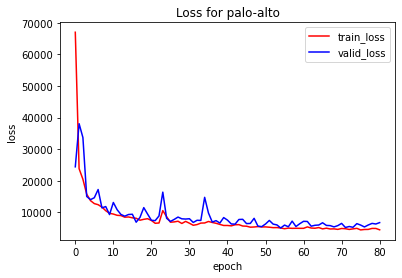

CPU times: user 5h 31min 9s, sys: 22min 48s, total: 5h 53min 57s
Wall time: 5h 53min 51s


In [17]:
%%time

batch_size = 128
n_epochs = 400
clip = 1

all_cities_best_train_loss = [float('inf')] * len(cities)
all_cities_best_valid_loss = [float('inf')] * len(cities)
city_index = 0

#train city models
for city in cities:
    train_losses = []
    valid_losses = []
    
    early_stop_counter = 0
    early_stop_criteria = 25
    
    print('city: ' + city)
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, drop_last = True)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle = True, drop_last = True)
    
    best_valid_loss = float('inf')
    for epoch in range(n_epochs):
    
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip)
        valid_loss = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            pickle.dump(model, open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + "_t05_d03_" + city, 'wb'))
            all_cities_best_train_loss[city_index] = train_loss
            all_cities_best_valid_loss[city_index] = valid_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter > early_stop_criteria:
                print("Stopped early at epoch " + str(epoch) + " due to overfit")
                break
            

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')
    
    
    city_index += 1
    
    #plot city loss
    plt.title("Loss for " + city)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(valid_losses, color ="blue", label = "valid_loss")
    plt.legend()
    plt.show()


In [18]:
all_cities_best_train_loss = np.array(all_cities_best_train_loss)
all_cities_best_valid_loss = np.array(all_cities_best_valid_loss)
np.set_printoptions(precision=2)

print(*cities, sep = ", ")
print(f'Best Train MSE Loss: {all_cities_best_train_loss} ')
print(f'Best Valid MSE Loss: {all_cities_best_valid_loss} ')

austin, miami, pittsburgh, dearborn, washington-dc, palo-alto
Best Train MSE Loss: [  3572.95  19939.83  21331.1  108511.01  11686.92   5022.98] 
Best Valid MSE Loss: [ 2830.96 13435.84 14378.21 66595.14 15700.79  5019.9 ] 


In [19]:
def predict(model, test_loader):
    
    model.eval()
    outputs = torch.zeros(1,60, 2).to(device)
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            
            src,trg = batch

            src = src.to(device)
            src = src.float()
            trg = trg.to(device)
            trg = trg.float()

            
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            outputs = torch.cat((outputs, output), 0)
        
    return outputs[1:]


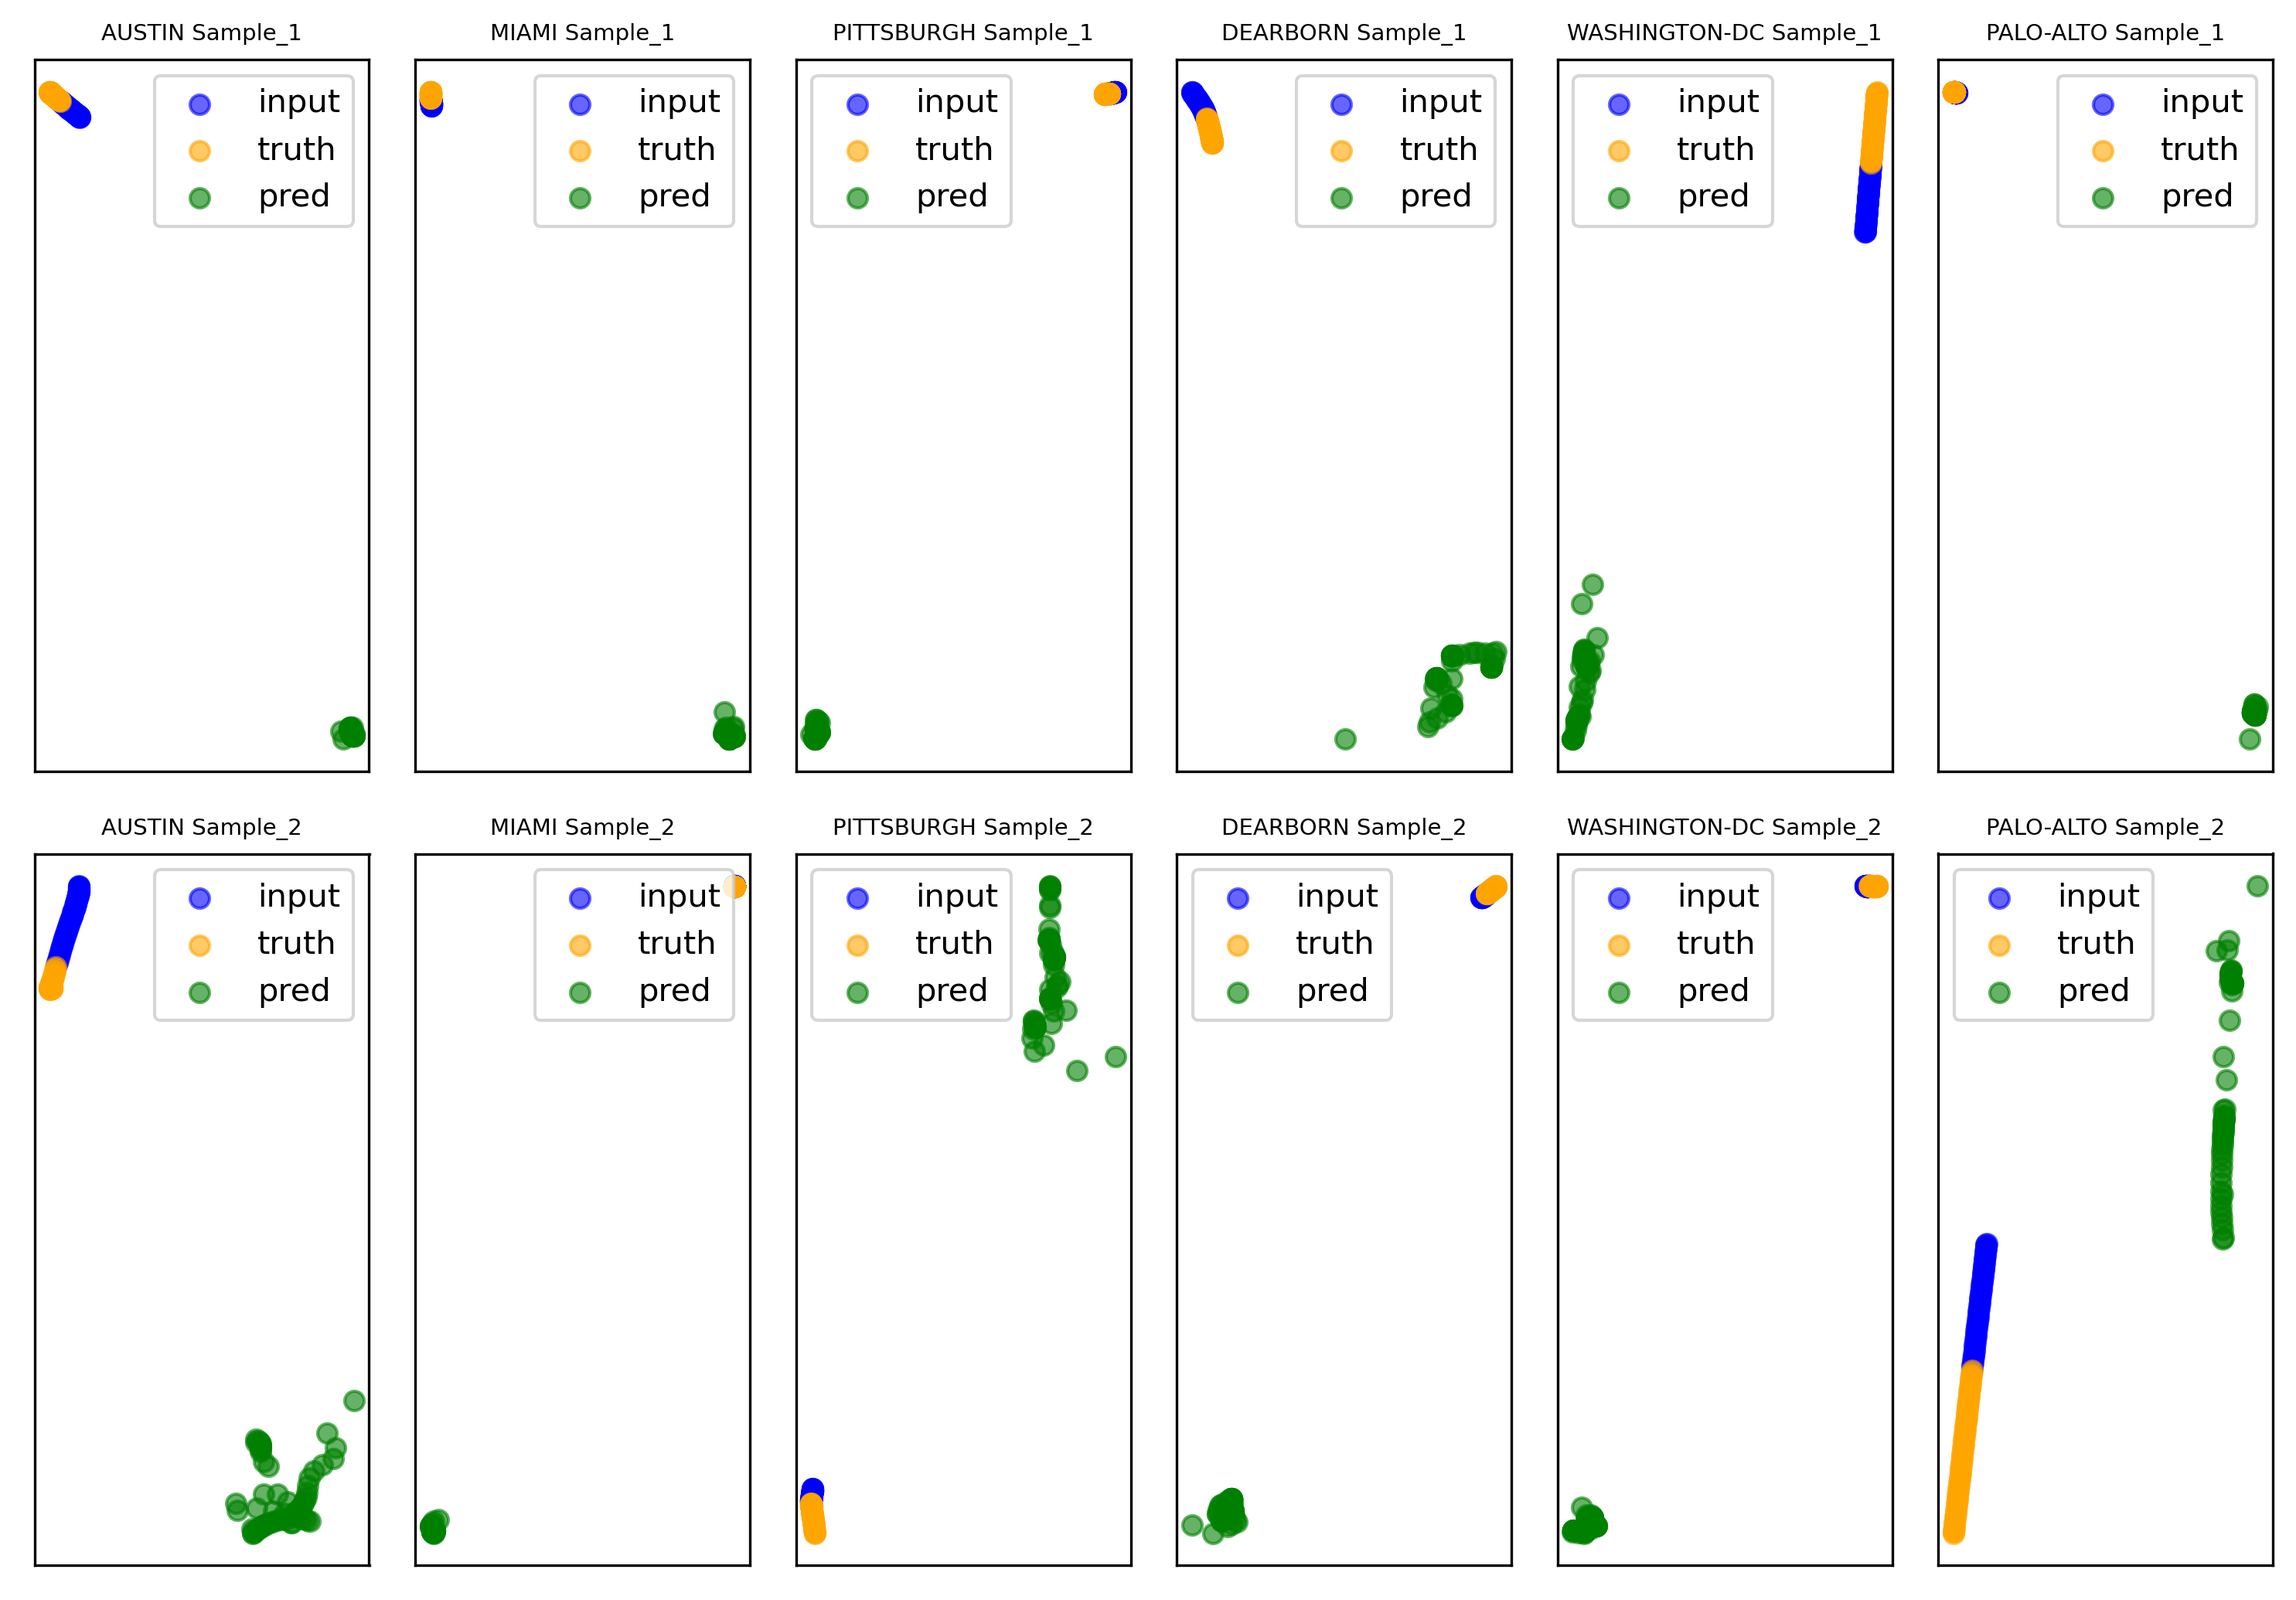

In [20]:
num_layers = 3 # change by hand to pick model
cols = np.array(['v' + str(i) for i in range(120)])
batch_size = 128
fig, axs = plt.subplots(2,6, figsize=(10,7), facecolor='w', edgecolor='k', dpi =300 )
# fig.subplots_adjust(hspace = .5, wspace=0.0001)

axs = axs.ravel()
for city, i in zip(cities,range(0,len(cities))):

    #loading model
    load_pred = pickle.load(open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + "_t05_d03_" + city, 'rb'))

    #get the training dataset/ return inputs, ouputs
    train_dataset = ArgoverseDataset(city = city, split = 'train')
    train_dataset_w = get_city_trajectories(city = city, split = 'train')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, drop_last = True)
    

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    load_pred = load_pred.to(device)
    #input/ truth/ prediction
    inp = train_dataset_w[0]
    inp_reshaped = inp.reshape(inp.shape[0],100)

    truth = train_dataset_w[1]
    truth_reshaped =  truth.reshape(truth.shape[0], 120)
    
    preds = predict(load_pred, train_loader)
    preds_reshaped = preds.reshape(preds.shape[0], 120)

    #plotting
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    
    
    sample = random.randint(0,len(preds_numpy)) 
    samp_1_truth = truth_reshaped[sample].reshape(60,2)
    samp_1_pred = preds_numpy[sample].reshape(60,2) 
    samp_1_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i].set_title(city.upper() + ' Sample_1',fontsize =7)
    axs[i].xaxis.set_ticks([])
    axs[i].yaxis.set_ticks([])
    axs[i].scatter(samp_1_inp[:,0], samp_1_inp[:,1], color = 'blue', label= 'input', alpha= .6)
    axs[i].scatter(samp_1_truth[:,0], samp_1_truth[:,1], color = 'orange',label= 'truth', alpha= .6)
    axs[i].scatter(samp_1_pred[:,0], samp_1_pred[:,1], color = 'green',label= 'pred', alpha= .6)
    axs[i].legend(loc='best')
    

    sample = random.randint(0,len(preds_numpy)) 
    samp_2_truth = truth_reshaped[sample].reshape(60,2)
    samp_2_pred = preds_numpy[sample].reshape(60,2)
    samp_2_inp = inp_reshaped[sample].reshape(50,2) 

    axs[i+6].set_title(city.upper() + ' Sample_2',fontsize =7)
    axs[i+6].xaxis.set_ticks([])
    axs[i+6].yaxis.set_ticks([])
    axs[i+6].scatter(samp_2_inp[:,0], samp_2_inp[:,1], color = 'blue', label= 'input', alpha= .6)
    axs[i+6].scatter(samp_2_truth[:,0], samp_2_truth[:,1], color = 'orange',label= 'truth', alpha= .6)
    axs[i+6].scatter(samp_2_pred[:,0], samp_2_pred[:,1], color = 'green', label= 'pred', alpha= .6)
    axs[i+6].legend(loc='best')

plt.tight_layout()
# train_pred = pd.concat(all_preds, ignore_index = True)
# train_pred

In [25]:
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []

for city in cities:
    load_pred = pickle.load(open('models/seq2seq_lstm_' + str(model.encoder.n_layers) + "_t05_d03_" + city, 'rb'))
    test_dataset = ArgoverseDataset(city = city, split = 'test')
    test_loader = DataLoader(test_dataset,batch_size=batch_size,drop_last = False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    load_pred = load_pred.to(device)
    preds = predict(load_pred, test_loader)
    preds_reshaped = preds.reshape(preds.shape[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [26]:
all_predictions

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,2.412402,-592.040283,3.961356,-574.863770,1.558878,-584.000977,11.034903,-583.642578,15.165148,...,25.698668,-597.573059,25.727606,-597.668335,25.851038,-597.859375,25.976206,-598.145813,26.031244,-598.695190
1,1_austin,-366.922455,1.875667,-342.118317,3.565501,-365.609955,-0.237226,-354.450806,14.088840,-349.734924,...,-344.035614,28.664242,-344.175079,28.740086,-344.294647,28.825298,-344.405701,28.911427,-344.511627,28.995853
2,2_austin,17.130877,-273.160431,16.367632,-275.604950,18.110323,-285.511353,31.317995,-289.653198,37.464767,...,57.791866,-241.212280,66.548965,-242.978851,79.736565,-240.241379,84.456551,-241.705978,87.148697,-248.474319
3,3_austin,-97.267303,1826.681030,-102.370056,1837.901245,-97.131378,1845.170044,-101.954880,1840.236206,-107.807610,...,-117.895477,1797.763550,-117.920250,1797.986938,-118.004974,1798.378418,-118.130432,1798.966309,-118.207550,1799.324341
4,4_austin,1057.996826,-555.822449,1071.079834,-582.113586,1080.268555,-585.072083,1086.407227,-582.384155,1089.091553,...,1118.262695,-621.473389,1119.207520,-621.914490,1120.009033,-622.246765,1120.727905,-622.526611,1121.388428,-622.777832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1284.219360,-443.305023,-1342.576416,-444.316895,-1358.438110,-467.267456,-1373.707397,-474.296082,-1378.539307,...,-1384.984497,-456.920654,-1385.270264,-457.005310,-1385.519165,-457.083740,-1385.842163,-457.316132,-1386.875610,-458.742279
29839,1682_palo-alto,96.741852,-211.673462,123.027878,-122.274246,210.147202,-50.505154,282.446014,-47.993160,267.037262,...,436.735779,-81.954407,431.880280,-105.753723,425.022095,-111.492485,431.561676,-113.731598,437.272064,-114.509476
29840,1683_palo-alto,-1492.516235,2159.292969,-1438.621460,2138.655273,-1435.849854,2122.873047,-1420.928833,2104.580566,-1421.932007,...,-1420.984009,2117.719727,-1421.019531,2117.764648,-1421.120972,2117.758301,-1421.262573,2117.724121,-1421.430786,2117.673096
29841,1684_palo-alto,1143.977905,1393.368164,1121.232056,1389.281616,1133.655151,1424.473145,1118.930786,1447.457642,1097.829346,...,1145.907349,1454.810425,1146.315063,1454.603271,1146.529663,1454.486328,1146.605835,1454.424683,1146.600220,1454.394897


In [27]:
all_predictions.to_csv('lstm_out.csv', index=False)

In [28]:
pd.read_csv('lstm_out.csv')

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,2.412402,-592.040300,3.961356,-574.863800,1.558878,-584.001000,11.034903,-583.64260,15.165148,...,25.698668,-597.573060,25.727606,-597.668330,25.851038,-597.859400,25.976206,-598.145800,26.031244,-598.695200
1,1_austin,-366.922450,1.875667,-342.118320,3.565501,-365.609950,-0.237226,-354.450800,14.08884,-349.734920,...,-344.035600,28.664242,-344.175080,28.740086,-344.294650,28.825298,-344.405700,28.911427,-344.511630,28.995853
2,2_austin,17.130877,-273.160430,16.367632,-275.604950,18.110323,-285.511350,31.317995,-289.65320,37.464767,...,57.791866,-241.212280,66.548965,-242.978850,79.736565,-240.241380,84.456550,-241.705980,87.148700,-248.474320
3,3_austin,-97.267300,1826.681000,-102.370056,1837.901200,-97.131380,1845.170000,-101.954880,1840.23620,-107.807610,...,-117.895480,1797.763500,-117.920250,1797.986900,-118.004974,1798.378400,-118.130430,1798.966300,-118.207550,1799.324300
4,4_austin,1057.996800,-555.822450,1071.079800,-582.113600,1080.268600,-585.072100,1086.407200,-582.38416,1089.091600,...,1118.262700,-621.473400,1119.207500,-621.914500,1120.009000,-622.246770,1120.727900,-622.526600,1121.388400,-622.777830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,1681_palo-alto,-1284.219400,-443.305020,-1342.576400,-444.316900,-1358.438100,-467.267460,-1373.707400,-474.29608,-1378.539300,...,-1384.984500,-456.920650,-1385.270300,-457.005300,-1385.519200,-457.083740,-1385.842200,-457.316130,-1386.875600,-458.742280
29839,1682_palo-alto,96.741850,-211.673460,123.027880,-122.274250,210.147200,-50.505154,282.446000,-47.99316,267.037260,...,436.735780,-81.954410,431.880280,-105.753720,425.022100,-111.492485,431.561680,-113.731600,437.272060,-114.509476
29840,1683_palo-alto,-1492.516200,2159.293000,-1438.621500,2138.655300,-1435.849900,2122.873000,-1420.928800,2104.58060,-1421.932000,...,-1420.984000,2117.719700,-1421.019500,2117.764600,-1421.121000,2117.758300,-1421.262600,2117.724000,-1421.430800,2117.673000
29841,1684_palo-alto,1143.977900,1393.368200,1121.232000,1389.281600,1133.655200,1424.473100,1118.930800,1447.45760,1097.829300,...,1145.907300,1454.810400,1146.315100,1454.603300,1146.529700,1454.486300,1146.605800,1454.424700,1146.600200,1454.394900
